In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

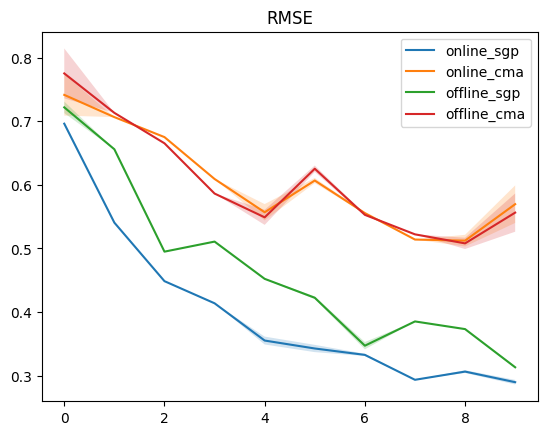

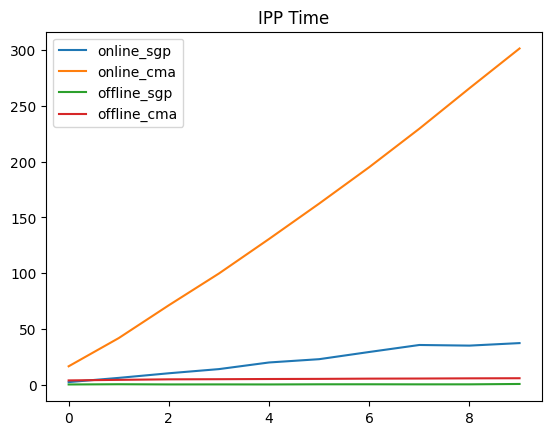

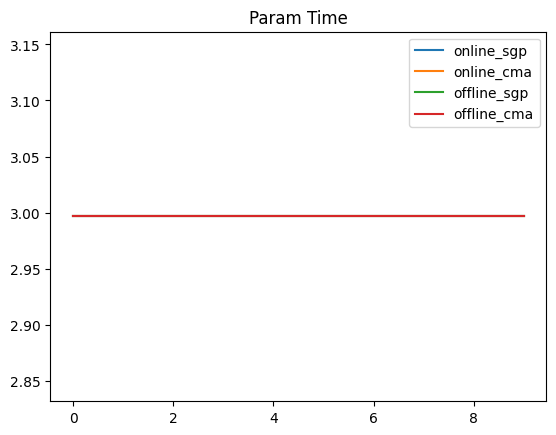

In [2]:
filename = f'../datasets/results/AIPP_4R_bathymetry_2S.json'
save_filename = filename[:-5] + '-{}.pdf'
results = json.load(open(filename, 'r'))

rmse = defaultdict(list)
rmse_std = defaultdict(list)

param_time = defaultdict(list)
param_time_std = defaultdict(list)

ipp_time = defaultdict(list)
ipp_time_std = defaultdict(list)

for num_sensors in results.keys():
    for method in  results[num_sensors].keys():
        for metric in results[num_sensors][method].keys():
            if metric=='RMSE':
                rmse[method].append(np.mean(results[num_sensors][method][metric]))
                rmse_std[method].append(np.std(results[num_sensors][method][metric]))
            elif metric=='ParamTime':
                param_time[method].append(np.mean(results[num_sensors][method][metric]))
                param_time_std[method].append(np.std(results[num_sensors][method][metric]))
            elif metric=='IPPTime':
                ipp_time[method].append(np.mean(results[num_sensors][method][metric]))
                ipp_time_std[method].append(np.std(results[num_sensors][method][metric]))

plt.figure()
for key in rmse.keys():
    plt.plot(rmse[key], label=key)
    plt.fill_between(np.arange(len(rmse[key])),
                     np.array(rmse[key])+rmse_std[key], 
                     np.array(rmse[key])-rmse_std[key], 
                     alpha=0.2)
plt.legend()
plt.title("RMSE")
plt.show()

plt.figure()
for key in ipp_time.keys():
    plt.plot(ipp_time[key], label=key)
plt.legend()
plt.title("IPP Time")
plt.show()

plt.figure()
for key in param_time.keys():
    plt.plot(param_time[key], label=key)
plt.legend()
plt.title("Param Time")
plt.show()